# Spherical latent space model for Networks: Model $\mathbb{S}^2$

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.SphericalM import *
from Modules.SphericalV import *
from Modules.SphericalC import *

## Network

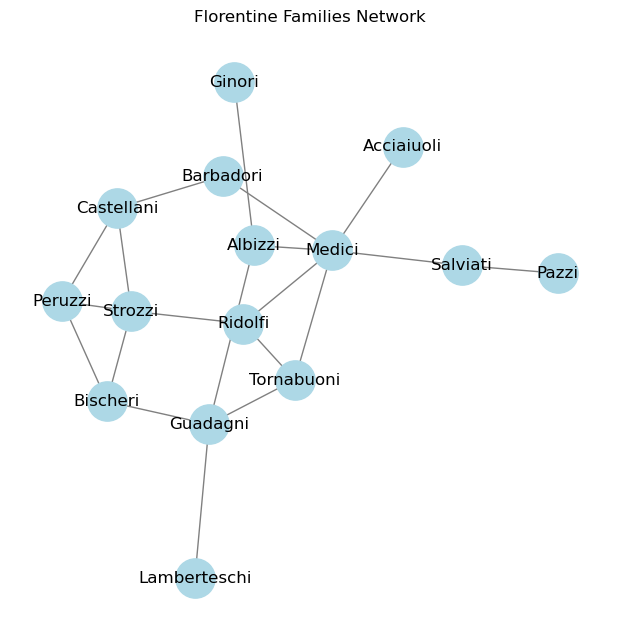

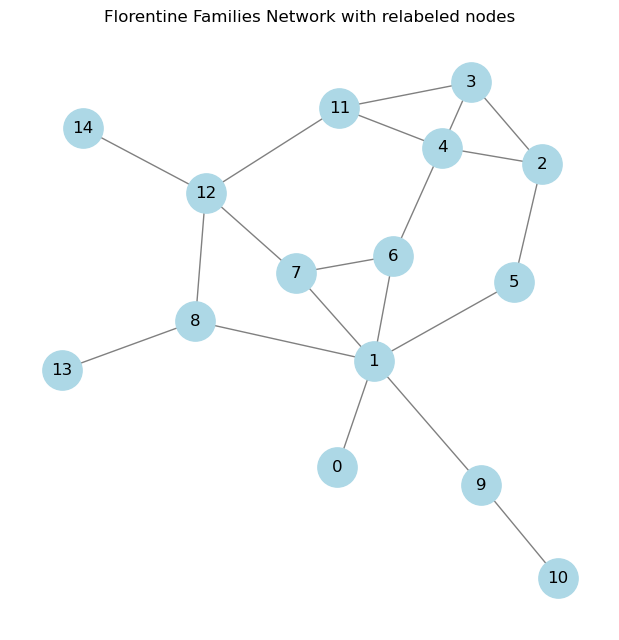

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


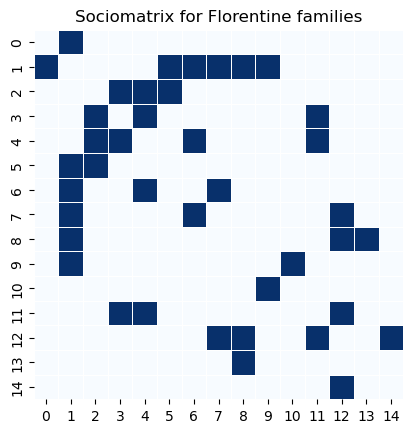

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix for Florentine families")
plt.show()

## Latent space

### Frequentist inference

Initial log-likelihood: -193.02135866349667
Final log-likelihood: -74.95494101031244
Final alpha: -1.9995595687685197


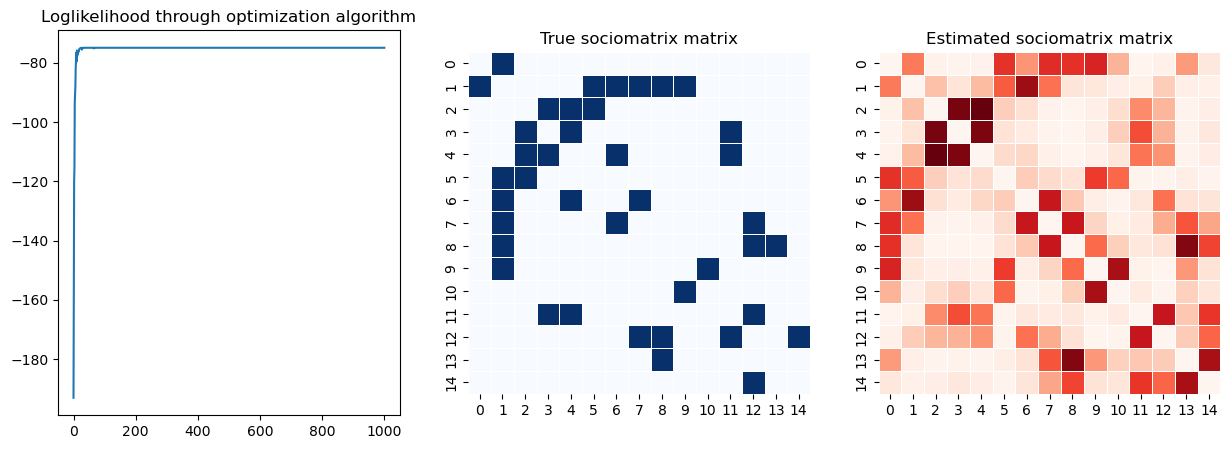

In [3]:

inclination_angles_rand = np.pi*np.random.rand(n)
azimutal_angles_rand = 2*np.pi*np.random.rand(n)
Z_init = np.stack((np.sin(inclination_angles_rand) * np.cos(azimutal_angles_rand),
                       np.sin(inclination_angles_rand) * np.sin(azimutal_angles_rand),
                       np.cos(inclination_angles_rand)), axis=1)
a_init = np.float64(np.random.randn())
b_init = np.float64(np.random.randn())
Z_ML, a_ML, b_ML, historyZ, historya, historyb  =  SearchingMLE(G,Z_init,a_init,b_init,1000)
print("Initial log-likelihood:", loglikelihood(G,Z_init,a_init,b_init))
print("Final log-likelihood:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Final alpha:", a_ML)
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = Z_ML[i].T @ Z_ML[j]
            Y_ML[i,j] = expit(a_ML + b_ML*d)


df = pd.DataFrame(Z_ML, columns=['x', 'y', 'z'])
df['node'] = df.index 
fig = px.scatter_3d(
    df, x='x', y='y', z='z',color_discrete_sequence=["blue"], opacity=0.7,
    hover_data={'node': True,'x': ':.2f','y': ':.2f','z': ':.2f'})

fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-1.1, 1.1]),yaxis=dict(range=[-1.1, 1.1]),zaxis=dict(range=[-1.1, 1.1]),
        aspectmode='cube'),
    title="Maximum likelihood estimation of latent positions")

fig.show()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot([loglikelihood(G, historyZ[t],historya[t],historyb[t]) for t in range(len(historya))])
plt.title("Loglikelihood through optimization algorithm")
plt.subplot(1,3,2)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,3,3)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

### Bayesian inference

In [9]:
# Execute HMC
number_of_samples = 10000
Z_init = Z_ML.copy()
a_init = a_ML
b_init = b_ML


print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init,b_init))

samples_Z, samples_a, samples_b, Hp, LogLp, acep_rate_history = ghmc(G, Z_init, a_init, b_init, number_of_samples, epsilon_init=0.0609, 
                                                                     std_dev_init_Z=0.1218, std_dev_init_a = 1.0, std_dev_init_b = 0.5, 
                                                                     percentage_warmup=0.01)
samples_Z = np.array([compute_starS2(samples_Z[i],Z_ML) for i in range(len(samples_Z))])
if np.isnan(samples_Z).any():
    list_nan = np.unique(np.where(np.isnan(samples_Z))[0])
    for index in list_nan:
        samples_Z[index] = Z_ML
# Estimators
## CM
from scipy.stats import circmean
inclination_angles_CM = circmean(np.arccos(samples_Z[:,:,2]), high=np.pi, low=0,axis=0)
azimutal_angles_CM = circmean(np.arctan2(samples_Z[:, :, 1], samples_Z[:, :, 0]), high=2*np.pi, low=0,axis=0)
Z_CM = np.stack((np.sin(inclination_angles_CM) * np.cos(azimutal_angles_CM),
                       np.sin(inclination_angles_CM) * np.sin(azimutal_angles_CM),
                       np.cos(inclination_angles_CM)), axis=1)
a_CM = np.mean(samples_a, axis=0)
b_CM = np.mean(samples_b, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]
b_MAP = samples_b[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP,b_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM,b_CM))

Log-L MLE: -74.95494101031244
Log-L starter: -74.95494101031244
Number of samples: 10000
Number of parameters: 17
Number of iterations: 10100
Number of warmup iterations: 100


  1%|          | 101/10100 [00:21<37:21,  4.46it/s]

Final parameters: epsilon=0.0378, L=26, std_dev_Z=0.0757, std_dev_a=1.0000, std_dev_b=0.5000


100%|██████████| 10100/10100 [43:23<00:00,  3.88it/s] 


Acceptance rate: 0.61754
Log-L MAP: -70.42692036466264
Log-L CM: -118.90241770653394


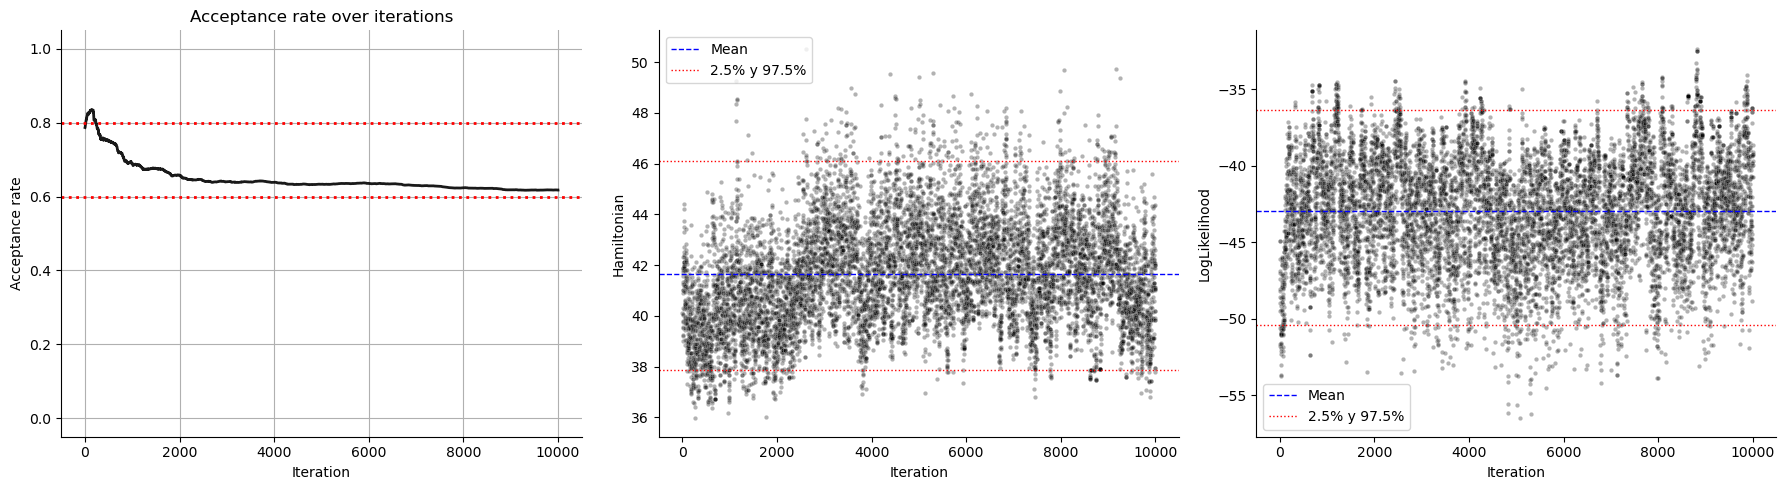

In [10]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

In [30]:
plot_Z_samples_3D(samples_Z[-1000:,:3,:])

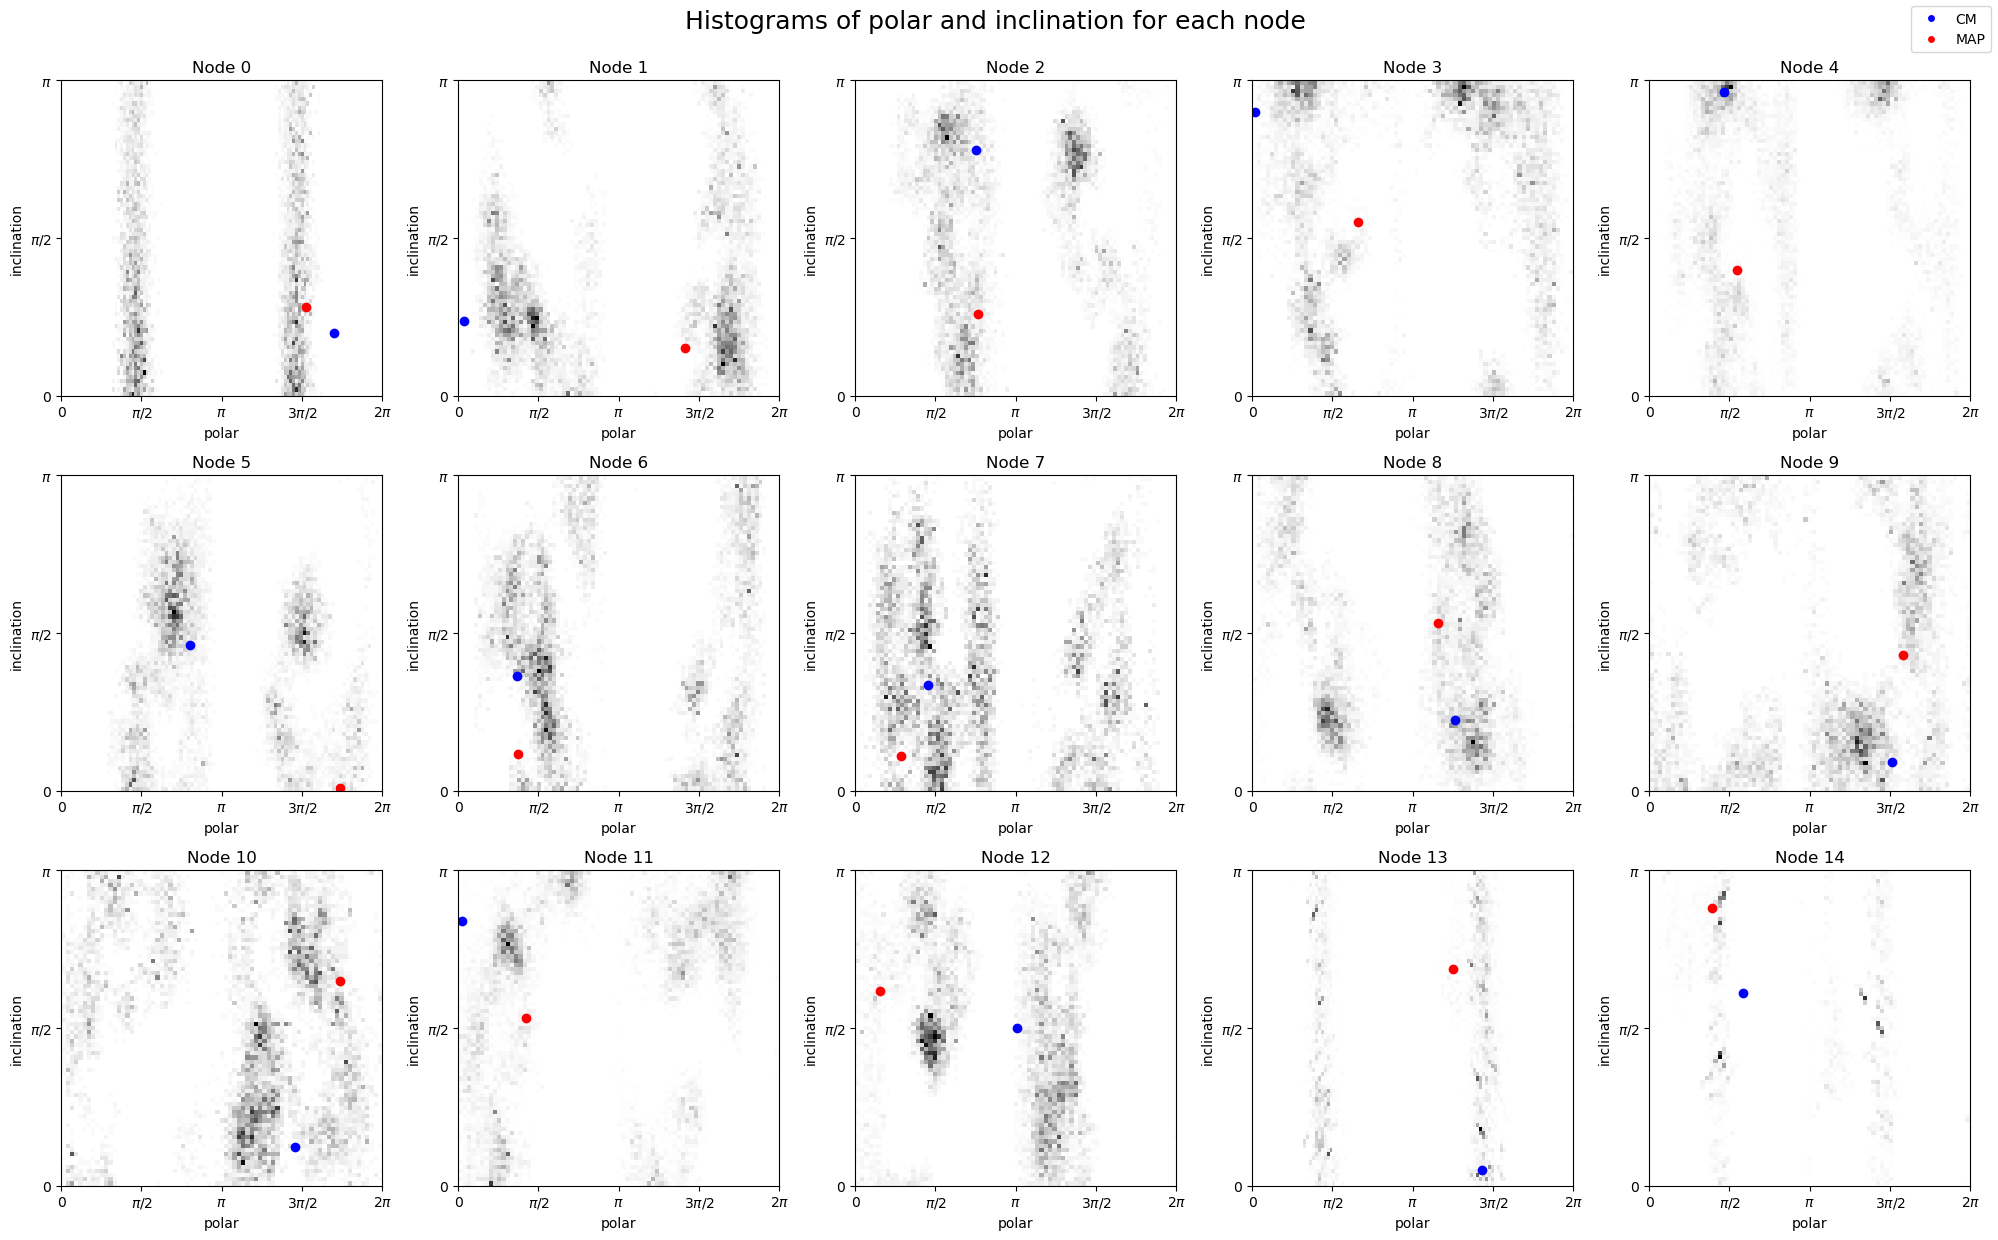

In [22]:
fig, axes = plt.subplots(3, 5, figsize=(20, 12))  
axes = axes.flatten()
for i in range(15):
    ax = axes[i]
    samples_i = samples_Z[:, i, :]  
    phi = np.mod(np.arctan2(samples_i[:,1], samples_i[:,0]), 2*np.pi)   
    theta = np.mod(np.arccos(samples_i[:,2]), np.pi)  
    h = ax.hist2d(phi, theta, bins=(75, 75), cmap='Greys')
    phi_cm = np.mod(np.arctan2(Z_CM[i,1], Z_CM[i,0]), 2*np.pi)
    theta_cm = np.arccos(Z_CM[i,2])
    phi_map = np.mod(np.arctan2(Z_MAP[i,1], Z_MAP[i,0]), 2*np.pi)
    theta_map = np.arccos(Z_MAP[i,2])
    ax.plot(phi_cm, theta_cm, 'bo', label='CM')
    ax.plot(phi_map, theta_map, 'ro', label='MAP')
    ax.set_title(f'Node {i}')
    ax.set_xlabel(r'polar')
    ax.set_ylabel(r'inclination')
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_yticklabels(['0', r'$\pi/2$', r'$\pi$'])
handles = [plt.Line2D([0], [0], marker='o', color='w', label='CM', markerfacecolor='b'),
           plt.Line2D([0], [0], marker='o', color='w', label='MAP', markerfacecolor='r')]
fig.legend(handles=handles, loc='upper right')
plt.tight_layout()
plt.suptitle("Histograms of polar and inclination for each node", y=1.03, fontsize=18)
plt.show()


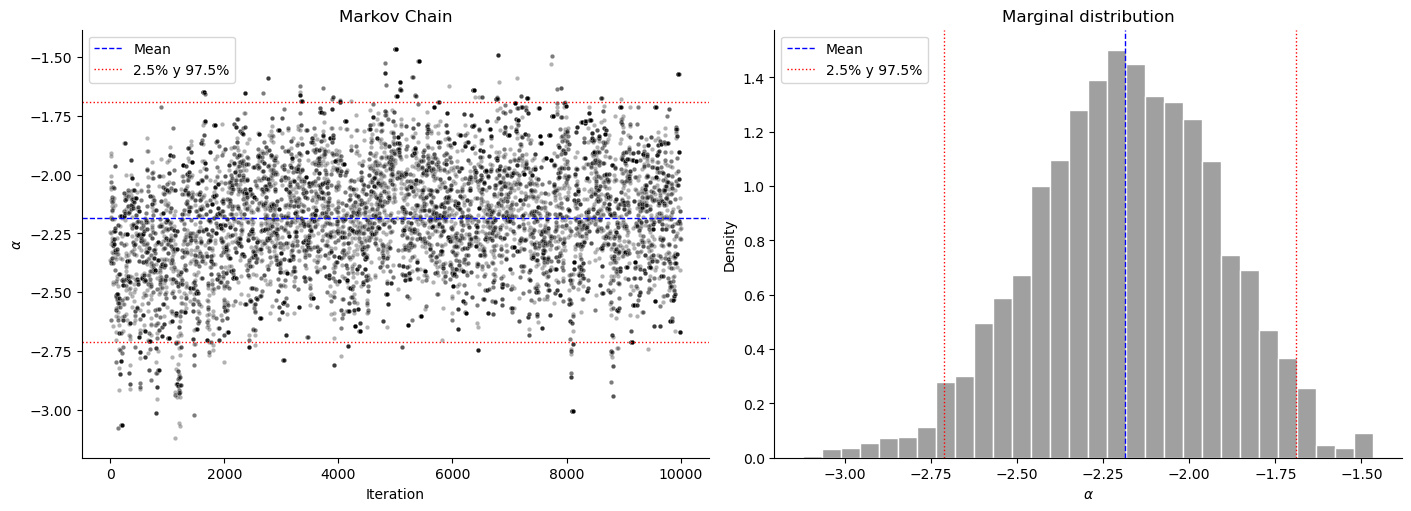

In [17]:
plot_alpha(samples_a)

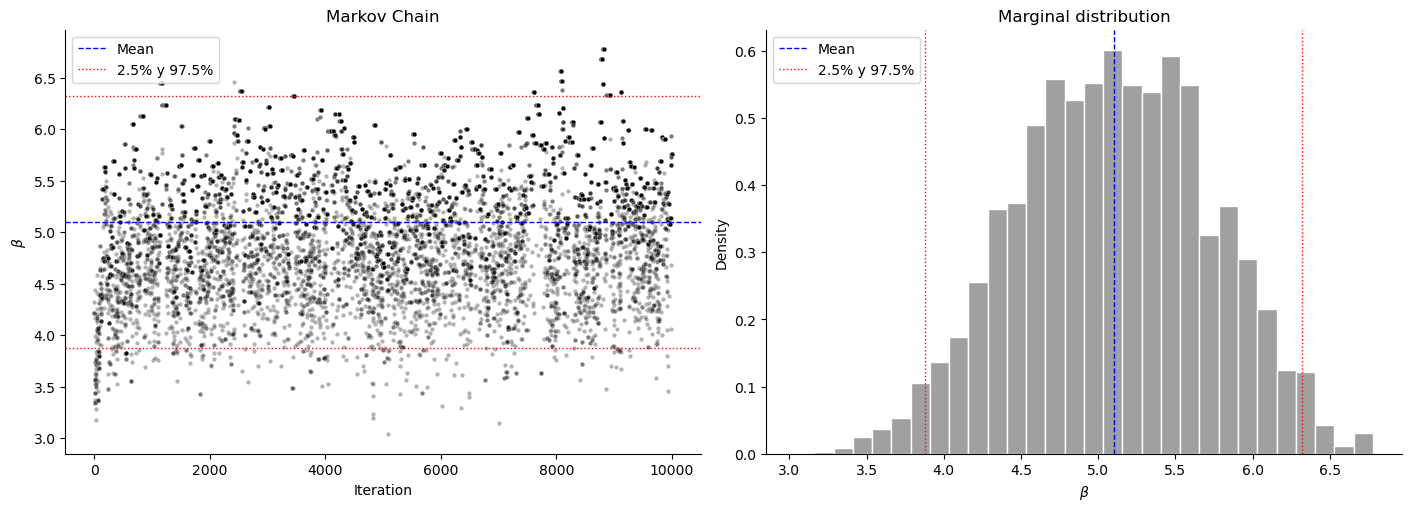

In [18]:
plot_beta(samples_b)

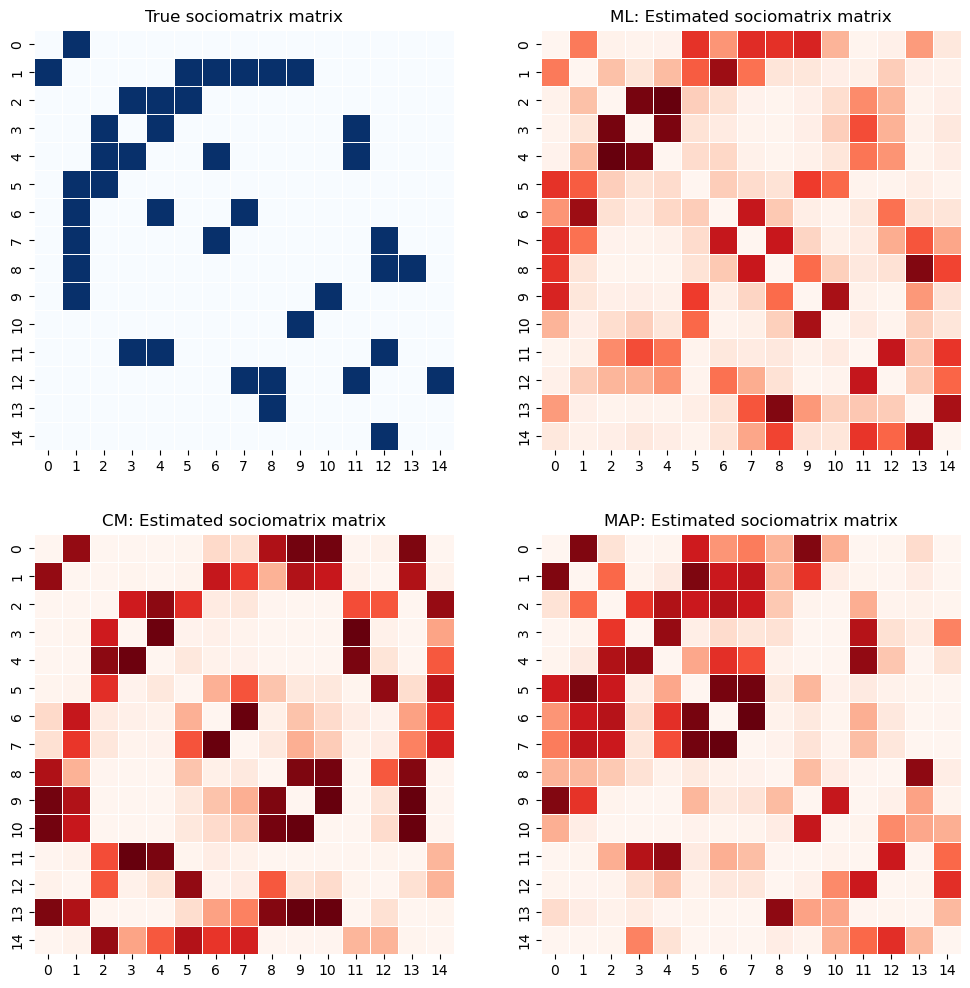

In [19]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_CM[i].T @ Z_CM[j]
            Y_CM[i,j] = expit(a_CM + b_CM * dist)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_MAP[i].T @ Z_MAP[j]
            Y_MAP[i,j] = expit(a_MAP + b_MAP * dist)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

In [20]:
clusteringS2(G,node_mapping, Z_ML, a_ML, b_ML, Z_MAP, a_MAP, b_MAP, Z_CM, a_CM, b_CM)

[[3, 4, 11, 12, 14], [0, 8, 9, 10, 13], [1, 2, 5, 6, 7]]

### Model Evaluation

#### Posterior predictive checking

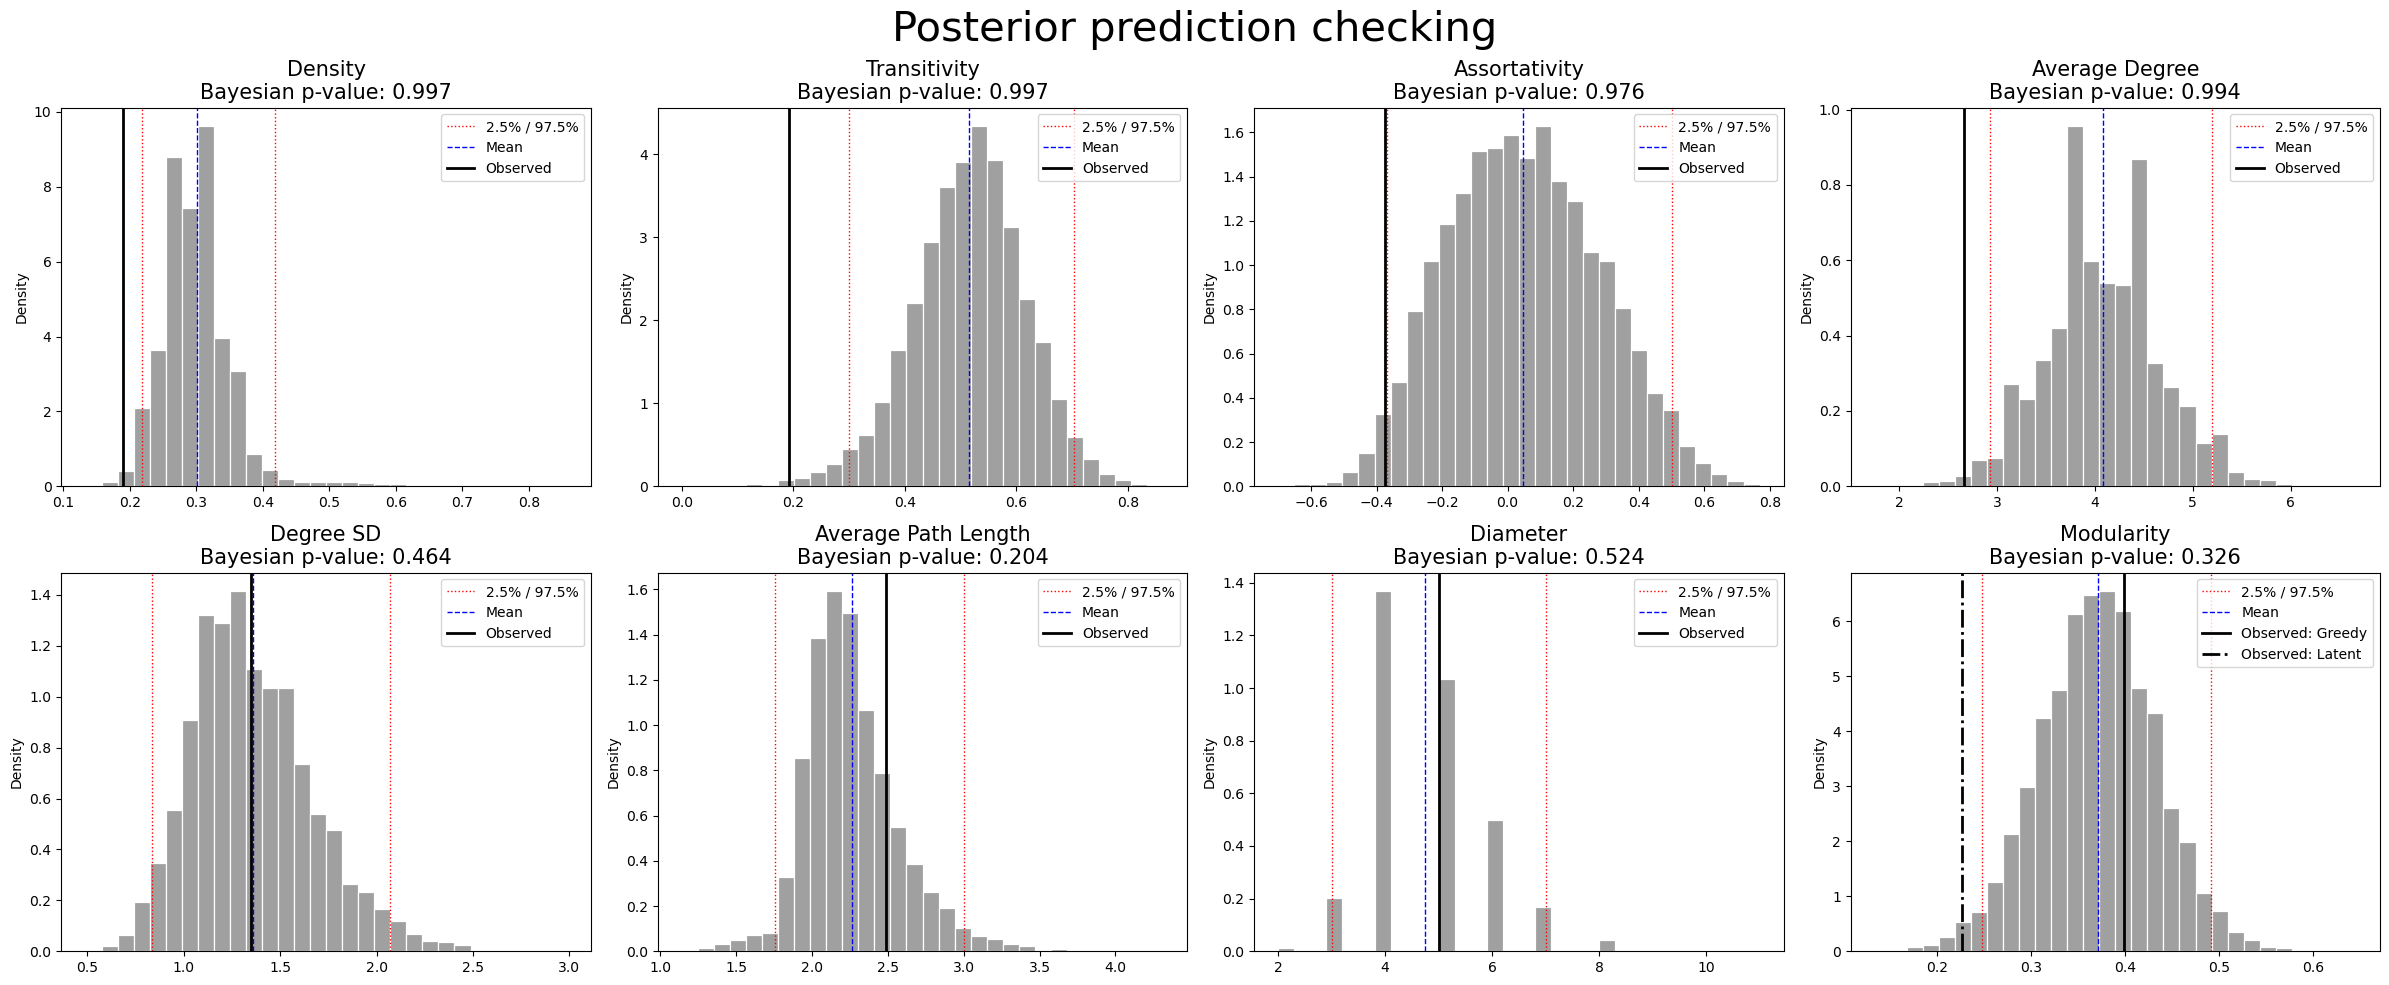

In [21]:
predictive_check(G,samples_Z,samples_a,samples_b)

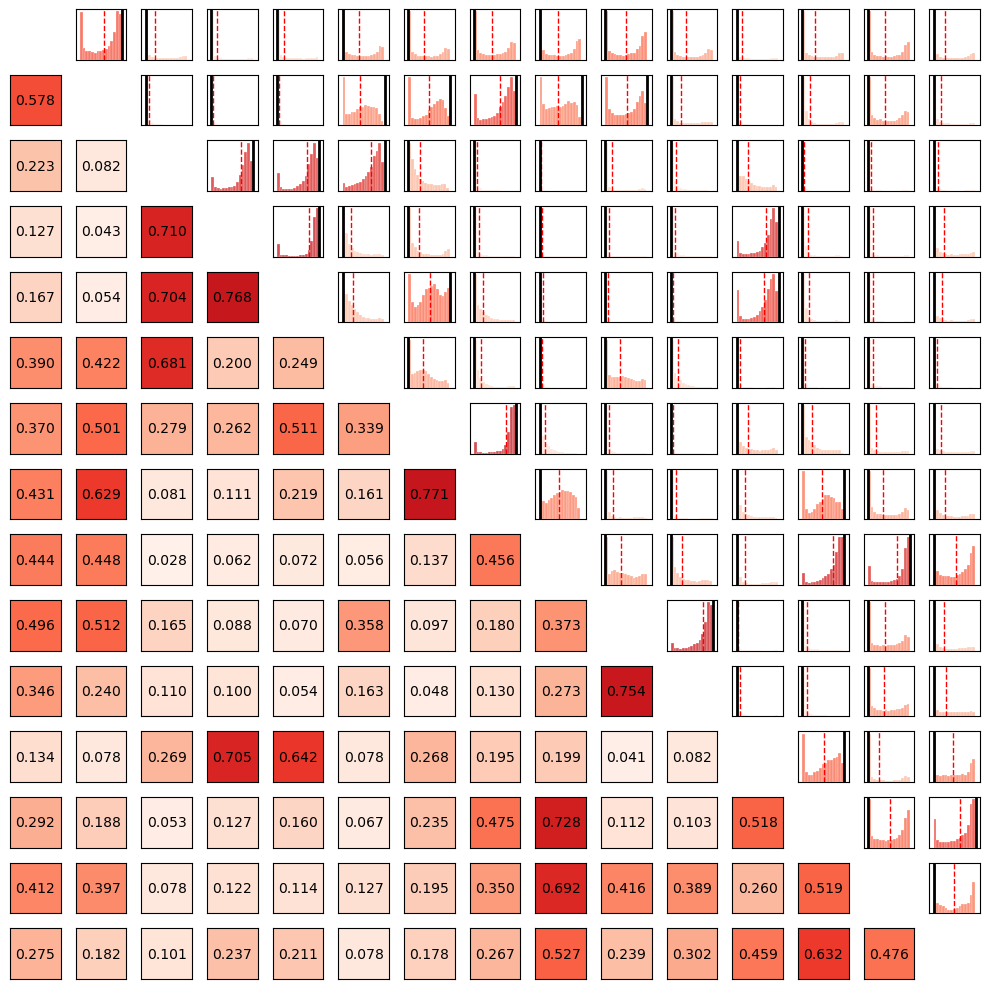

In [23]:
plot_pairwise_sociomatrix(G,samples_Z, samples_a, samples_b, Y)

#### Model comparison criteria

In [24]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a, samples_b)
waic = compute_WAIC(log_lik)
dic = compute_DIC_S1(log_lik, Y, samples_Z, samples_a, samples_b)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")

WAIC: 483.8946
DIC: 87.9968


#### Prior predictive checking

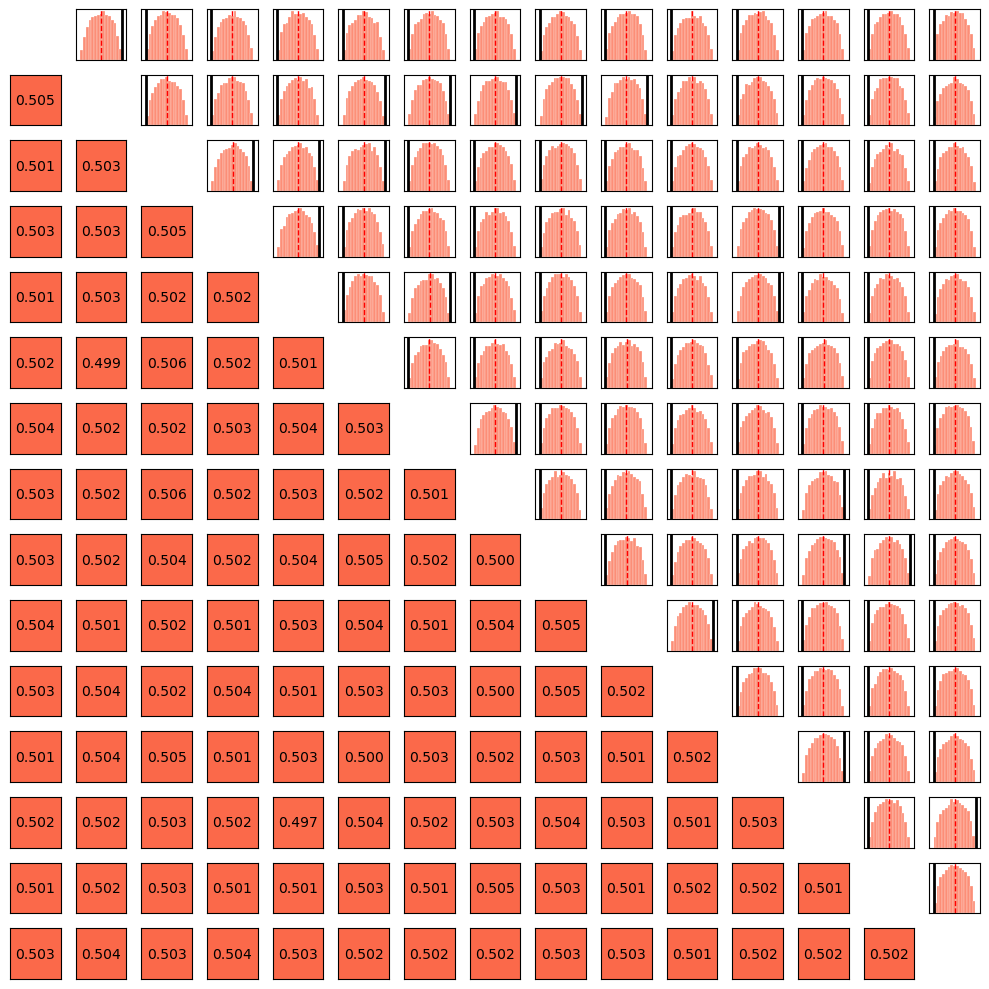

In [25]:
angles_prior = 2*np.pi*np.random.rand(number_of_samples, n)
samples_Z_prior = np.stack((np.cos(angles_prior), np.sin(angles_prior)), axis=2)
samples_a_prior = np.random.randn(number_of_samples)
samples_b_prior = np.random.randn(number_of_samples)
plot_pairwise_sociomatrix(G,samples_Z_prior, samples_a_prior, samples_b_prior, Y)

#### Prediction evaluation

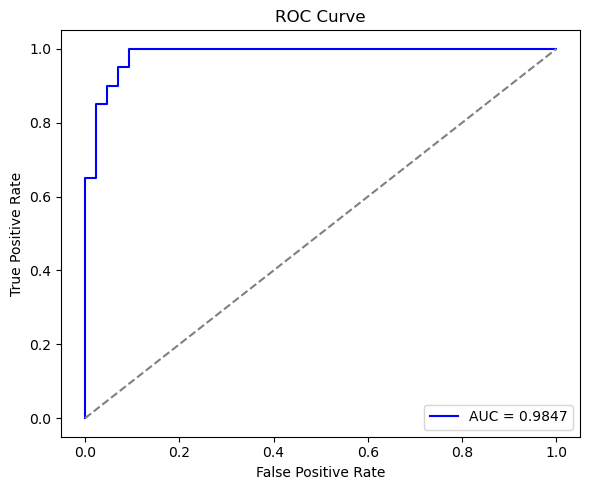

{'roc_auc': 0.9847058823529412,
 'confusion_matrix': {'tp': 17, 'tn': 83, 'fp': 2, 'fn': 3},
 'accuracy': 0.9523809523809523,
 'precision': 0.8947368421052632,
 'recall': 0.85,
 'f1_score': 0.8717948717948718,
 'specificity': 0.9764705882352941}

In [26]:
roc_analysis(Y, posterior_connection_probs(samples_Z, samples_a, samples_b))

In [31]:
saving_results((samples_Z, samples_a, samples_b), Hp, LogLp, acep_rate_history, filename="FlorentineS2.xlsx")

Saving samples...
Saving diagnostics...
Results saved to FlorentineS2.xlsx


## References

[1]